In [1]:
import msgpack
import pandas as pd

* For each bracket...
* Find the best score at each decision point

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

In [3]:
pd.__version__

'0.23.0'

In [4]:
# from sklearn.datasets import make_circles
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
# X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
# X2[:, 0] += 0.6
# X_info = np.concatenate((X1, X2))
# y = np.concatenate((y1, y2 + 2))

# df = pd.DataFrame(X_info)
# df["y"] = y
# ax = df.plot.scatter(x=0, y=1, c="y", cmap="tab10", vmax=10, alpha=0.03)
# # ax.yaxis.set_major_locator(plt.NullLocator())
# # ax.xaxis.set_major_formatter(plt.NullFormatter())
# ax.set_ylabel("")
# plt.savefig("figs/synthetic-dataset.png", dpi=300, bbox_inches="tight")

In [5]:
today = "2019-06-22-more-aggressive"

def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
    
with open(f"out/{today}-histories-2.msgpack", "rb") as f:
    histories = msgpack.load(f)

histories = _to_str_keys(histories)

In [6]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [7]:
hyperband_params = [
    tuple({k: v for k, v in h["params"].items() if "hidden" not in k}.items())
    for hist in histories["hyperband"]
    for h in hist
]
passive_params = [
    tuple({k: v for k, v in h["params"].items() if "hidden" not in k}.items())
    for hist in histories["passive"]
    for h in hist
]


hyperband_params = {h for h in hyperband_params}
passive_params = {h for h in passive_params}

same = hyperband_params.intersection(passive_params)
len(same), len(hyperband_params), len(same) / len(hyperband_params)

(200, 15120, 0.013227513227513227)

In [8]:
from sklearn.utils import check_random_state
def shape_history(history, seed=None, **kwargs):
#     global hist_df
    rng = check_random_state(int(seed))
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    print(seed, kwargs)
    start = history[0]["elapsed_wall_time"]
    
    if seed:
        model_history = toolz.groupby("model_id", history)
        for hist in model_history.values():
            for h in hist:
                h["elapsed_wall_time"] += rng.uniform(0, 0.3)
        hist = sum(model_history.values(), [])
        hist_df = pd.DataFrame(hist)
        hist_df.sort_values(by="elapsed_wall_time", inplace=True)
    else:
        hist_df = pd.DataFrame(history)
    
    for _, row in hist_df.iterrows():
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [9]:
import pandas as pd

hists = [
    shape_history(hist, seed=False, alg=alg, k=k)
    for alg, hists in histories.items()
    for k, hist in enumerate(hists)
#     for seed in range(3)
    for seed in [False]
]

False {'alg': 'hyperband', 'k': 0}
False {'alg': 'hyperband', 'k': 1}
False {'alg': 'hyperband', 'k': 2}
False {'alg': 'hyperband', 'k': 3}
False {'alg': 'hyperband', 'k': 4}
False {'alg': 'hyperband', 'k': 5}
False {'alg': 'hyperband', 'k': 6}
False {'alg': 'hyperband', 'k': 7}
False {'alg': 'hyperband', 'k': 8}
False {'alg': 'hyperband', 'k': 9}
False {'alg': 'hyperband', 'k': 10}
False {'alg': 'hyperband', 'k': 11}
False {'alg': 'hyperband', 'k': 12}
False {'alg': 'hyperband', 'k': 13}
False {'alg': 'hyperband', 'k': 14}
False {'alg': 'hyperband', 'k': 15}
False {'alg': 'hyperband', 'k': 16}
False {'alg': 'hyperband', 'k': 17}
False {'alg': 'hyperband', 'k': 18}
False {'alg': 'hyperband', 'k': 19}
False {'alg': 'hyperband', 'k': 20}
False {'alg': 'hyperband', 'k': 21}
False {'alg': 'hyperband', 'k': 22}
False {'alg': 'hyperband', 'k': 23}
False {'alg': 'hyperband', 'k': 24}
False {'alg': 'hyperband', 'k': 25}
False {'alg': 'hyperband', 'k': 26}
False {'alg': 'hyperband', 'k': 27}
Fa

In [10]:
import numpy as np
def smooth(df):
    col = "cumulative_partial_fit_calls"
    df[col] = np.round(df[col], decimals=-1) + 5
    return df
    
    return pd.DataFrame({"best_score": avg_score, "cumulative_partial_fit_calls": avg_calls, **summary})

raw_dfs = [pd.DataFrame(hist) for hist in hists]
print(sum(len(df) for df in raw_dfs))
dfs = [smooth(df) for df in raw_dfs]
df = pd.concat(dfs)
print(df.alg.unique())
print(df.cumulative_partial_fit_calls.describe())
print(len(df))
df.head()

353960
['hyperband' 'passive']
count    353960.00000
mean       2834.79961
std        1653.04906
min           5.00000
25%        1405.00000
50%        2825.00000
75%        4265.00000
max        5745.00000
Name: cumulative_partial_fit_calls, dtype: float64
353960


,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,k,random_state
0,hyperband,0.238652,5,0.000000,0,400
1,hyperband,0.274945,5,0.000002,0,400
2,hyperband,0.280144,5,0.000003,0,400
3,hyperband,0.280144,5,0.000005,0,400
4,hyperband,0.280144,5,0.000005,0,400


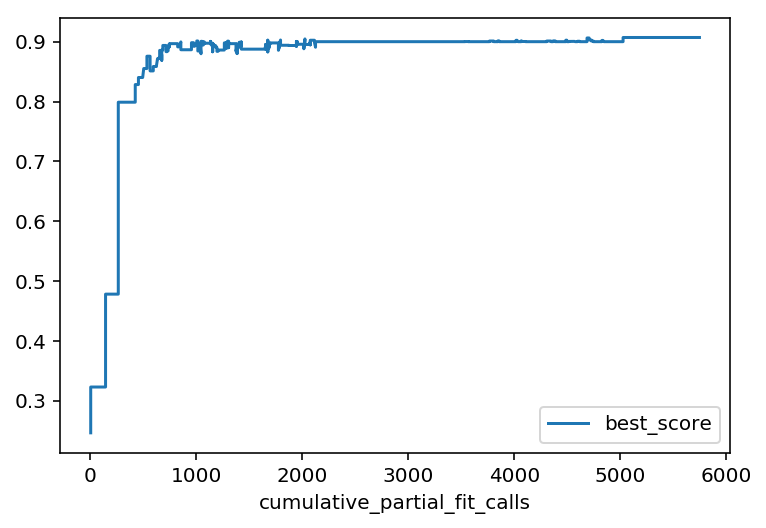

In [49]:
show = [df for df in raw_dfs 
        if df.loc[0, "alg"] == "hyperband"
        and df.loc[0, "random_state"] == 404]
show = show[0]

show.plot(x="cumulative_partial_fit_calls", y="best_score")

In [12]:
import seaborn as sns

df["epochs"] = df["cumulative_partial_fit_calls"] / 3

kwargs = dict(
    index="epochs",
    values="best_score",
    columns="alg",
)

middle = df.pivot_table(aggfunc="mean", **kwargs)
lower = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.25), **kwargs)
upper = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.75), **kwargs)

In [13]:
middle.describe()

alg,hyperband,passive
count,575.000000,571.000000
mean,0.817592,0.730113
std,0.158388,0.138269
min,0.271190,0.270413
25%,0.805835,0.669794
50%,0.904627,0.776351
75%,0.909320,0.837689
max,0.911537,0.863900


passive
hyperband


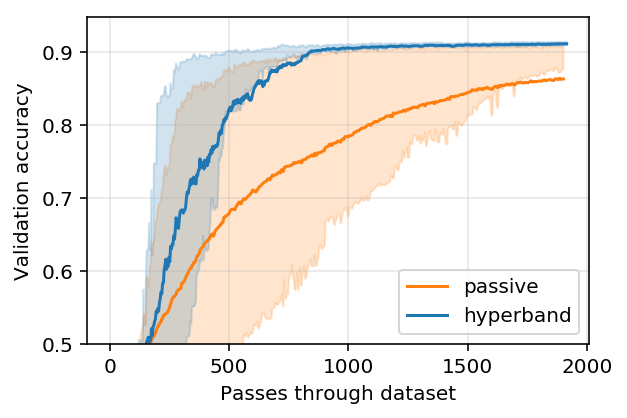

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    print(alg)
    show_mid = middle[alg].dropna()
    show_low = lower[alg].dropna()
    show_upp = upper[alg].dropna()
    
    show_mid.plot(ax=ax, color=colors[alg])
#     show_low.plot(ax=ax, color=colors[alg], style="--")
    col = "epochs"
    ax.fill_between(show_low.index, show_low.values, show_upp.values, alpha=0.20, color=colors[alg])
ax.set_ylim(0.5, None)
ax.legend(loc="lower right")
ax.grid(linestyle="-", alpha=0.3)
ax.set_ylabel("Validation accuracy")

ax.set_xlabel("Passes through dataset")
plt.savefig("figs/synthetic-val-acc.pdf", bbox_inches="tight")

In [15]:
scores = pd.read_csv(f"out/{today}-best-scores.csv")
scores.columns

Index(['activation', 'alg', 'alpha', 'batch_size', 'hidden_layer_sizes',
       'learning_rate', 'learning_rate_init', 'momentum', 'n_iter_no_change',
       'nesterovs_momentum', 'power_t', 'score', 'solver'],
      dtype='object')

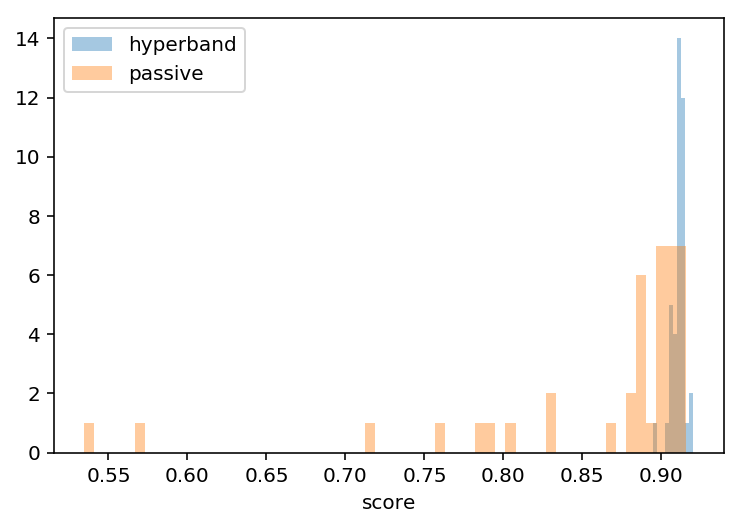

In [16]:
fig, ax = plt.subplots()

bins = {"hyperband": 10, "passive": 60}

for alg in scores.alg.unique():
    show = scores[scores.alg == alg]
    sns.distplot(show.score, ax=ax, kde=False, label=alg, bins=bins[alg])
# ax.set_xlim(0.8, None)
ax.legend(loc="best")

In [17]:
params = pd.read_csv(f"out/{today}-best-params.csv")

params[params.alg == "hyperband"]

,activation,alg,alpha,batch_size,best_score_,hidden_layer_sizes,learning_rate,learning_rate_init,momentum,n_iter_no_change,nesterovs_momentum,power_t,solver
0,relu,hyperband,0.000025,256,0.904719,"(24,)",constant,0.004402,0.987988,inf,True,0.296196,sgd
1,relu,hyperband,0.000218,64,0.909918,"(12, 12)",constant,0.007869,0.830831,inf,True,0.515616,sgd
2,relu,hyperband,0.000012,256,0.910418,"(12, 12)",constant,0.007309,0.973974,inf,True,0.152052,sgd
3,relu,hyperband,0.000009,32,0.914617,"(12, 12)",constant,0.003217,0.746747,inf,True,0.830330,sgd
4,relu,hyperband,0.000014,32,0.907219,"(6, 6, 6, 6)",constant,0.003996,0.452452,inf,True,0.662963,sgd
5,relu,hyperband,0.000009,32,0.910418,"(12, 12)",constant,0.008589,0.183183,inf,True,0.775075,sgd
6,relu,hyperband,0.000004,256,0.907019,"(12, 12)",constant,0.009549,0.860861,inf,True,0.884785,sgd
7,relu,hyperband,0.000040,32,0.906319,"(12, 12)",constant,0.001002,0.970971,inf,True,0.114414,sgd
8,relu,hyperband,0.000835,128,0.908418,"(12, 12)",constant,0.000687,0.994995,inf,True,0.448348,sgd
9,relu,hyperband,0.000163,64,0.911218,"(12, 12)",invscaling,0.008870,0.939940,inf,True,0.104004,sgd
